In [108]:
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap


from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier 


from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind


In [61]:
data = fetch_acs_income()
# convert to df
raw_data = pd.DataFrame(data.data, columns=data.feature_names)
raw_data['target'] = data.target

# drop unknown feature
df = raw_data.drop(columns=['ST'], errors='ignore')

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  29000.0


In [62]:
# check for missing values
df.isna().sum()

AGEP      0
COW       0
SCHL      0
MAR       0
OCCP      0
POBP      0
RELP      0
WKHP      0
SEX       0
RAC1P     0
target    0
dtype: int64

# Pre-processing

## Re-grouping data

In [63]:
df = df.copy()

# Categorize AGEP into bins
age_bins = [15, 25, 45, 60, float('inf')]
age_labels = ['15_25', '25_45', '45_60', '60_plus']
df['AGEP'] = pd.cut(df['AGEP'], bins=age_bins, labels=age_labels, right=False)

# Binarize MAR
df['MAR'] = df['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
df = df[df['RAC1P'].isin(valid_rac1p_values)]


## Subsampling data

In [64]:
df['strata'] = df[['RAC1P','SEX', 'MAR', 'AGEP']].astype(str).agg('_'.join, axis=1)

# remove instances if they belong to a intersectional group with less than two occurences
df = df[df.groupby('strata')['strata'].transform('count') >= 2] 

sampled_data,_ = train_test_split(df, 
                             train_size=500_000, 
                             stratify=df['strata'], 
                             random_state=42)

sampled_data.drop('strata', axis=1, inplace=True)

In [65]:
len(sampled_data)

500000

Check for proportions

In [66]:
print(df['SEX'].value_counts(normalize=True))
print(sampled_data['SEX'].value_counts(normalize=True))

print(df['MAR'].value_counts(normalize=True))
print(sampled_data['MAR'].value_counts(normalize=True))


SEX
1.0    0.520814
2.0    0.479186
Name: proportion, dtype: float64
SEX
1.0    0.520816
2.0    0.479184
Name: proportion, dtype: float64
MAR
1    0.54716
0    0.45284
Name: proportion, dtype: float64
MAR
1    0.547154
0    0.452846
Name: proportion, dtype: float64


In [67]:
print(df['RAC1P'].value_counts(normalize=True))
print(sampled_data['RAC1P'].value_counts(normalize=True))

RAC1P
1.0    0.788277
2.0    0.089613
6.0    0.058538
8.0    0.038182
9.0    0.025392
Name: proportion, dtype: float64
RAC1P
1.0    0.788278
2.0    0.089614
6.0    0.058534
8.0    0.038180
9.0    0.025394
Name: proportion, dtype: float64


# Data visualisation

In [68]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX',  'RAC1P'] 

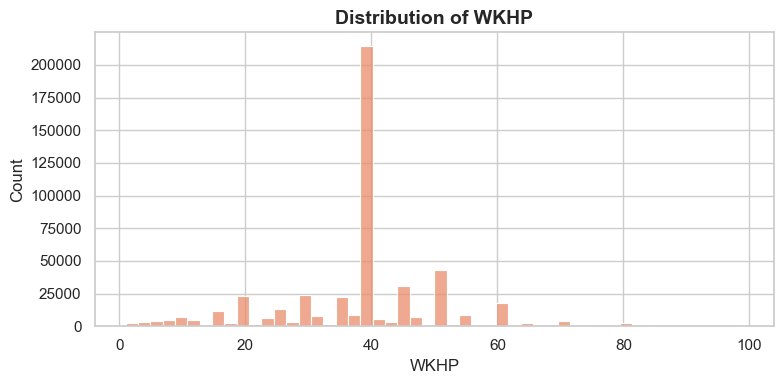

In [69]:
sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(sampled_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

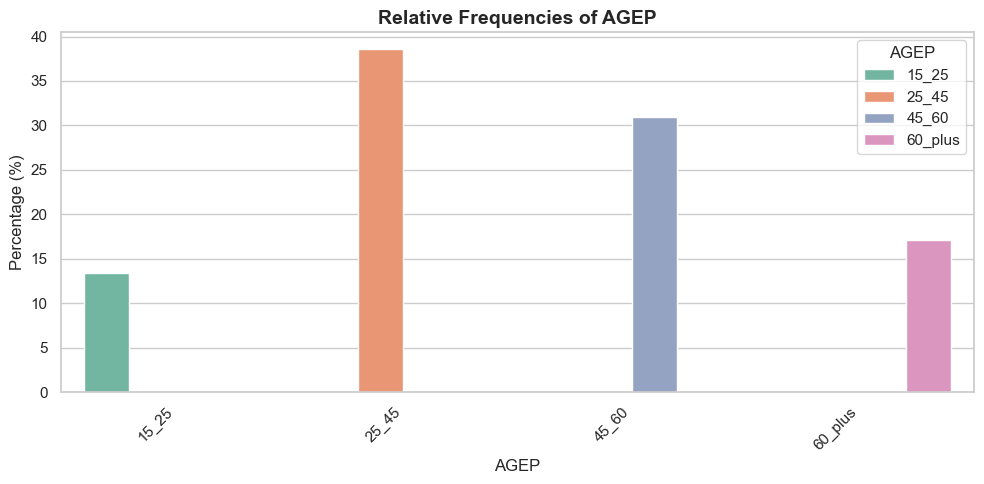

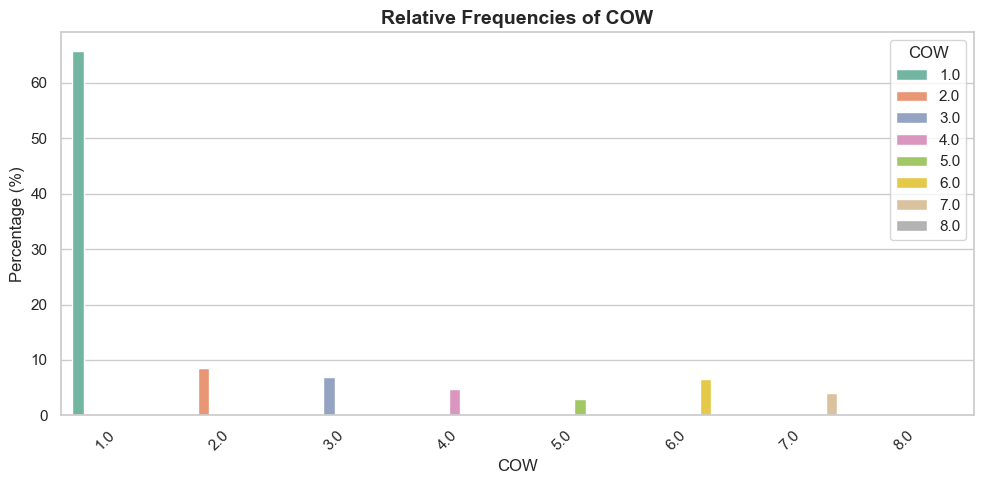

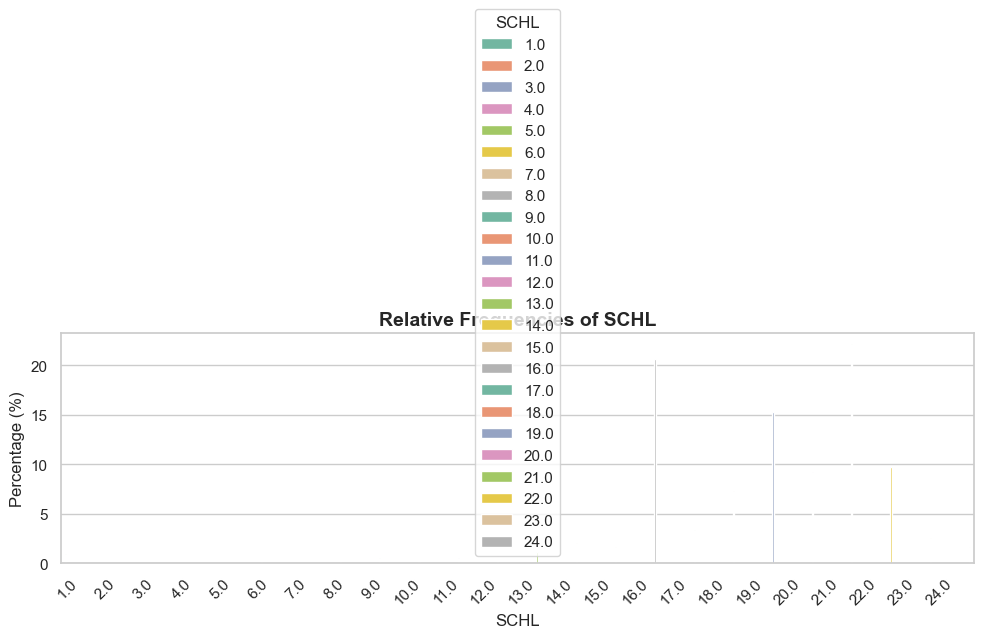

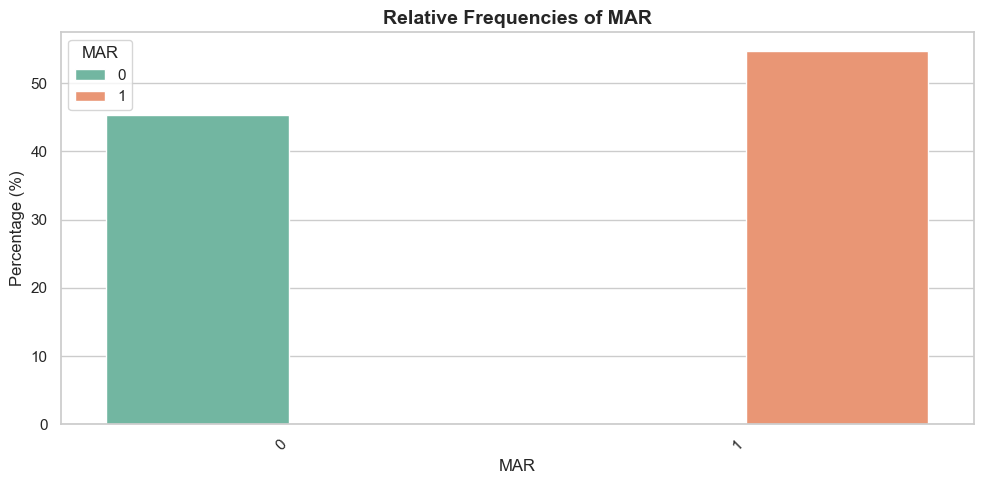

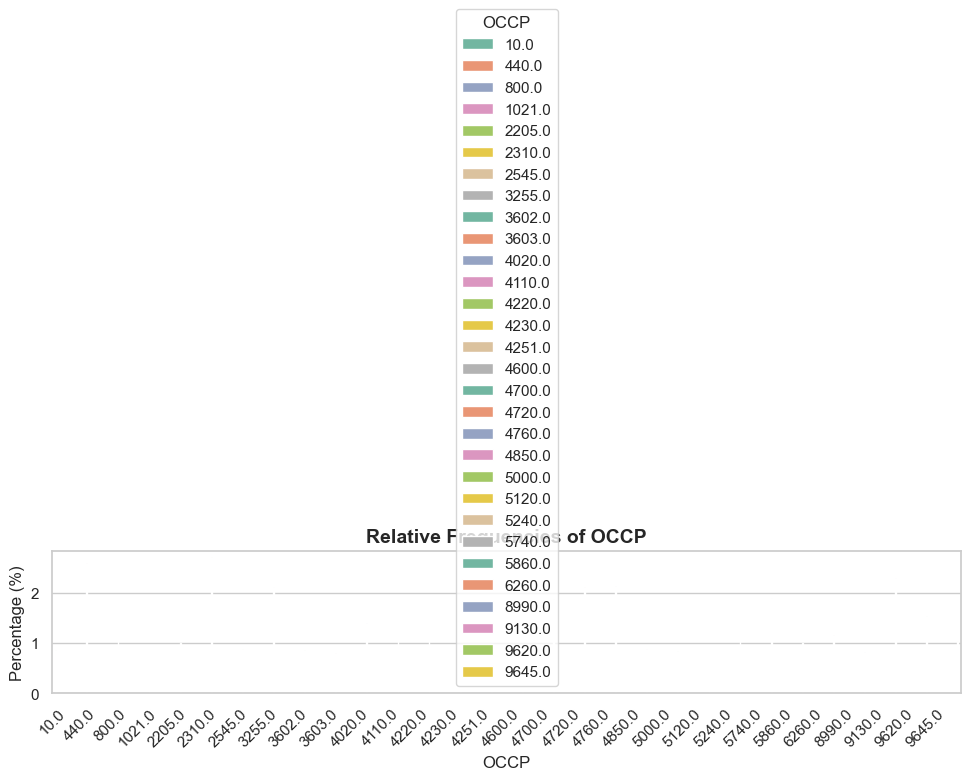

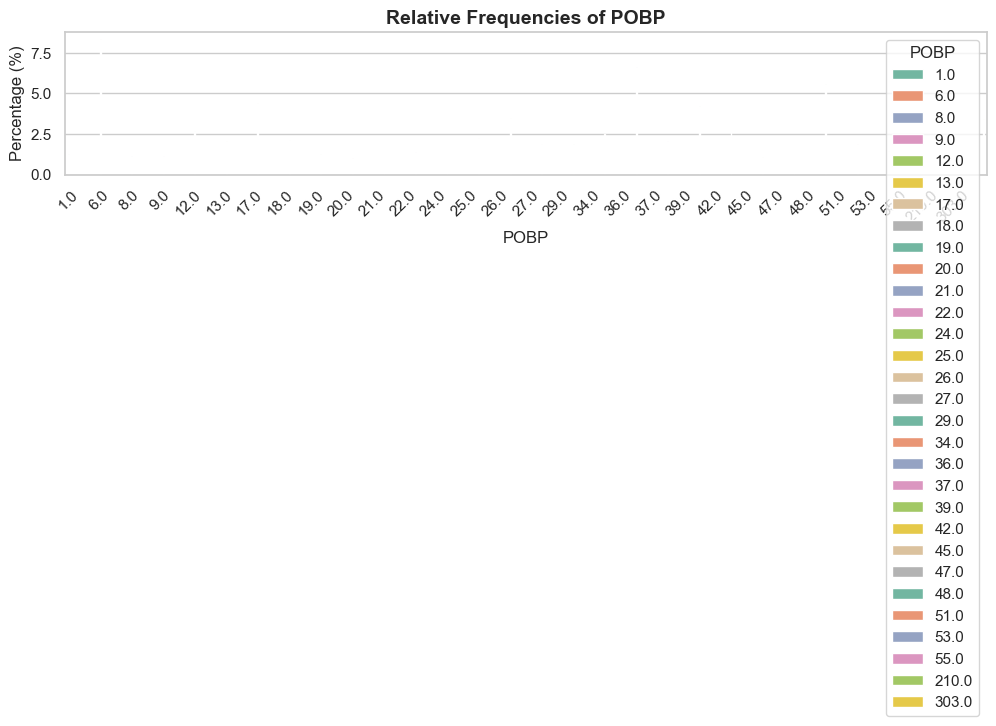

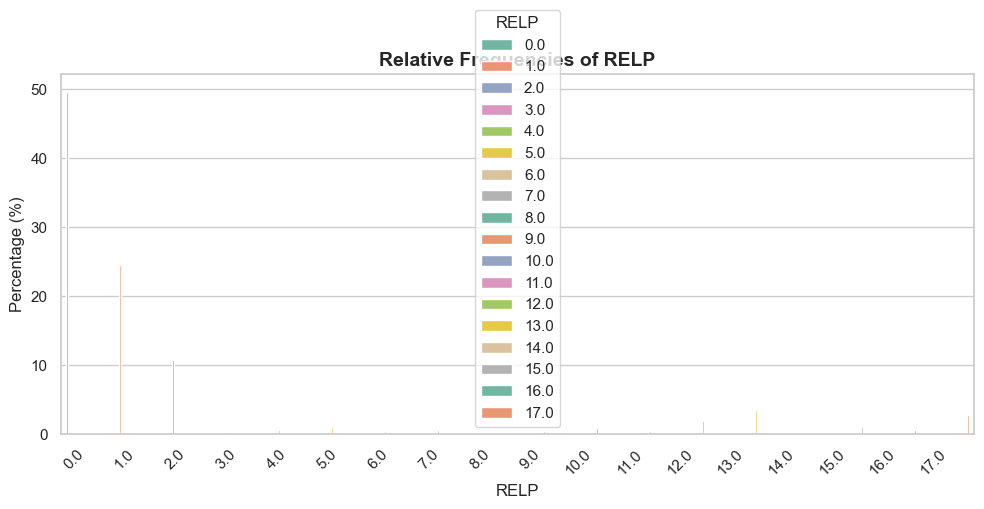

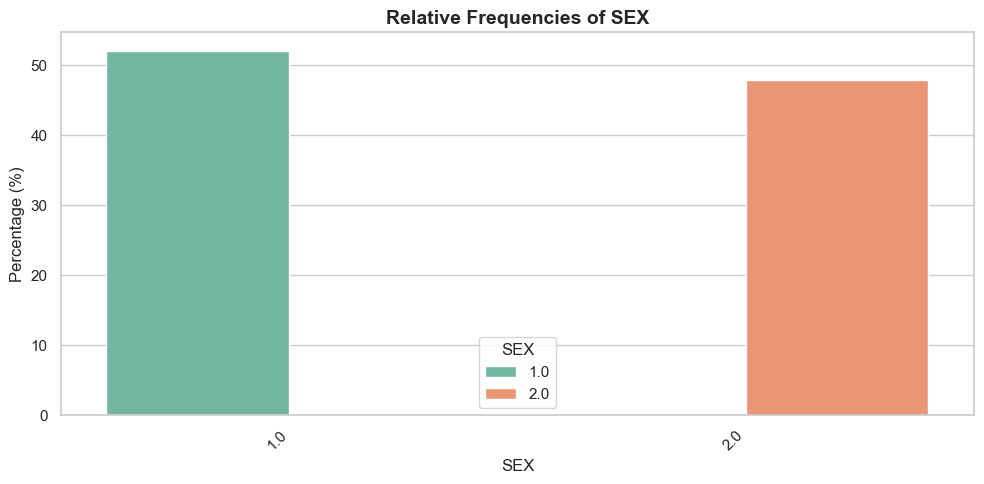

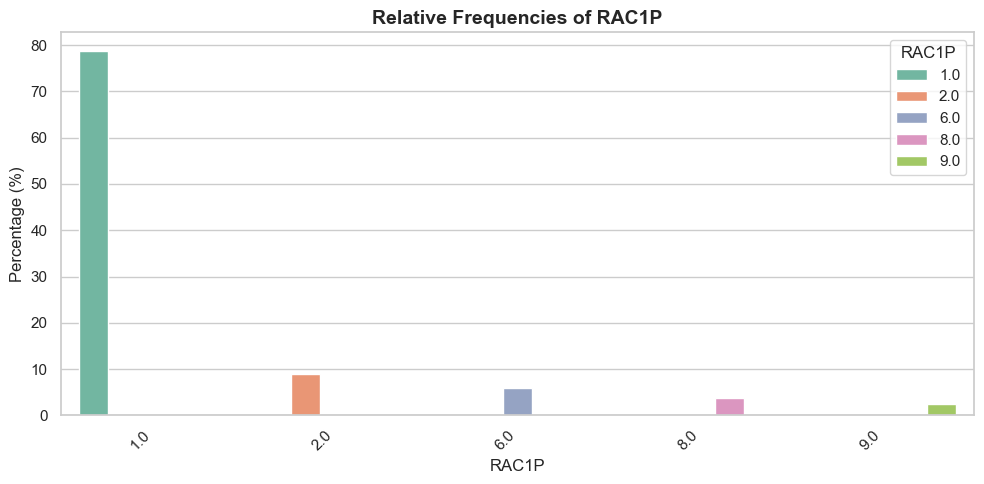

In [70]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Creating thresholds and splitting datasets

In [71]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols) 
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(sampled_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)

In [103]:
y_train_arr = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_arr = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [87]:
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(feature_names) + numeric_cols

# **XGBoostClassifier** 

Hyperparamter grid search and training the best model

In [74]:
param_dist = {
    'n_estimators': randint(100, 700),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

n_iter = 20
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
results = []

for i, params in enumerate(param_list):
    print(f"\n Running trial {i+1}/{n_iter}...")
    print("Params:", params)
    start = time.time()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        **params
    )

    model.fit(X_train_enc, y_train)
    y_val_pred = model.predict(X_val_enc)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    duration = time.time() - start
    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

    results.append((params, val_f1))

# Get best model
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 (macro): {best_score:.4f}")

# Train best model on full training data
best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

# Final test evaluation
y_test_pred = best_model.predict(X_test_enc)



 Running trial 1/20...
Params: {'colsample_bytree': 0.6872700594236812, 'gamma': 4.75357153204958, 'learning_rate': 0.22959818254342154, 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'subsample': 0.9330880728874675}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 1/20 — Val F1 (macro): 0.7994 — Time: 0.8s

 Running trial 2/20...
Params: {'colsample_bytree': 0.8005575058716043, 'gamma': 3.540362888980227, 'learning_rate': 0.016175348288740735, 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.21233911067827616, 'subsample': 0.5909124836035503}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:50:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 2/20 — Val F1 (macro): 0.7709 — Time: 1.7s

 Running trial 3/20...
Params: {'colsample_bytree': 0.5917022549267169, 'gamma': 1.5212112147976886, 'learning_rate': 0.16742692948967136, 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': 0.5247746602583891, 'reg_lambda': 0.3998609717152555, 'subsample': 0.5233328316068078}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 3/20 — Val F1 (macro): 0.8021 — Time: 3.8s

 Running trial 4/20...
Params: {'colsample_bytree': 0.9868777594207296, 'gamma': 1.1638567021515211, 'learning_rate': 0.03718193035984624, 'max_depth': 5, 'n_estimators': 666, 'reg_alpha': 0.9832308858067882, 'reg_lambda': 0.4667628932479799, 'subsample': 0.9299702033681603}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:50:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 4/20 — Val F1 (macro): 0.7902 — Time: 2.2s

 Running trial 5/20...
Params: {'colsample_bytree': 0.8401537692938899, 'gamma': 2.2524962598477147, 'learning_rate': 0.013979488347959958, 'max_depth': 11, 'n_estimators': 415, 'reg_alpha': 0.5632882178455393, 'reg_lambda': 0.3854165025399161, 'subsample': 0.5079831261101071}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:50:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 5/20 — Val F1 (macro): 0.7873 — Time: 3.6s

 Running trial 6/20...
Params: {'colsample_bytree': 0.6154469128110744, 'gamma': 1.2051273301300585, 'learning_rate': 0.21497905564763747, 'max_depth': 14, 'n_estimators': 608, 'reg_alpha': 0.8331949117361643, 'reg_lambda': 0.17336465350777208, 'subsample': 0.6955303037866204}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 6/20 — Val F1 (macro): 0.8002 — Time: 3.7s

 Running trial 7/20...
Params: {'colsample_bytree': 0.5911180438940311, 'gamma': 3.7768070515882624, 'learning_rate': 0.13754676234737342, 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': 0.5677003278199915, 'reg_lambda': 0.03131329245555858, 'subsample': 0.9211423872974993}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 7/20 — Val F1 (macro): 0.7969 — Time: 0.9s

 Running trial 8/20...
Params: {'colsample_bytree': 0.7248770666848828, 'gamma': 1.9757511800090721, 'learning_rate': 0.28799765973813823, 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'subsample': 0.6626651653816322}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 8/20 — Val F1 (macro): 0.7996 — Time: 2.5s

 Running trial 9/20...
Params: {'colsample_bytree': 0.6943386448447411, 'gamma': 1.3567451588694794, 'learning_rate': 0.2586212527455788, 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': 0.28093450968738076, 'reg_lambda': 0.5426960831582485, 'subsample': 0.5704621124873813}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 9/20 — Val F1 (macro): 0.8021 — Time: 1.9s

 Running trial 10/20...
Params: {'colsample_bytree': 0.9010984903770198, 'gamma': 0.3727532183988541, 'learning_rate': 0.3060660809801552, 'max_depth': 10, 'n_estimators': 228, 'reg_alpha': 0.1987156815341724, 'reg_lambda': 0.005522117123602399, 'subsample': 0.9077307142274171}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 10/20 — Val F1 (macro): 0.7996 — Time: 1.2s

 Running trial 11/20...
Params: {'colsample_bytree': 0.8534286719238086, 'gamma': 3.6450358402049368, 'learning_rate': 0.24138110400578372, 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': 0.3584657285442726, 'reg_lambda': 0.11586905952512971, 'subsample': 0.9315517129377968}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 11/20 — Val F1 (macro): 0.8026 — Time: 1.9s

 Running trial 12/20...
Params: {'colsample_bytree': 0.811649063413779, 'gamma': 1.654490124263246, 'learning_rate': 0.02906750508580709, 'max_depth': 9, 'n_estimators': 673, 'reg_alpha': 0.32518332202674705, 'reg_lambda': 0.7296061783380641, 'subsample': 0.8187787356776066}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 12/20 — Val F1 (macro): 0.7963 — Time: 3.5s

 Running trial 13/20...
Params: {'colsample_bytree': 0.9436063712881633, 'gamma': 2.3610746258097466, 'learning_rate': 0.04587827378149051, 'max_depth': 5, 'n_estimators': 104, 'reg_alpha': 0.5612771975694962, 'reg_lambda': 0.770967179954561, 'subsample': 0.7468977981821954}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 13/20 — Val F1 (macro): 0.7700 — Time: 0.5s

 Running trial 14/20...
Params: {'colsample_bytree': 0.7613664146909971, 'gamma': 2.137705091792748, 'learning_rate': 0.017625738023228556, 'max_depth': 5, 'n_estimators': 674, 'reg_alpha': 0.8957635956735194, 'reg_lambda': 0.47537022318211175, 'subsample': 0.7816377859881918}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 14/20 — Val F1 (macro): 0.7815 — Time: 2.4s

 Running trial 15/20...
Params: {'colsample_bytree': 0.8477580432130638, 'gamma': 0.6966572720293784, 'learning_rate': 0.1913252137833452, 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': 0.22879816549162246, 'reg_lambda': 0.07697990982879299, 'subsample': 0.6448757264568841}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 15/20 — Val F1 (macro): 0.7990 — Time: 3.7s

 Running trial 16/20...
Params: {'colsample_bytree': 0.5806106436270022, 'gamma': 4.648488261712865, 'learning_rate': 0.2524361138693251, 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': 0.2184404372168336, 'reg_lambda': 0.4165099478703662, 'subsample': 0.9416401294594341}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 16/20 — Val F1 (macro): 0.8003 — Time: 0.6s

 Running trial 17/20...
Params: {'colsample_bytree': 0.662172510502637, 'gamma': 0.6104397735033668, 'learning_rate': 0.11688935142309247, 'max_depth': 3, 'n_estimators': 484, 'reg_alpha': 0.22793516254194168, 'reg_lambda': 0.4271077886262563, 'subsample': 0.9090073829612466}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 17/20 — Val F1 (macro): 0.7927 — Time: 1.1s

 Running trial 18/20...
Params: {'colsample_bytree': 0.9303652916281717, 'gamma': 0.03476065265595352, 'learning_rate': 0.16322419077326972, 'max_depth': 11, 'n_estimators': 417, 'reg_alpha': 0.22210781047073025, 'reg_lambda': 0.1198653673336828, 'subsample': 0.668807585701814}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 18/20 — Val F1 (macro): 0.8026 — Time: 2.3s

 Running trial 19/20...
Params: {'colsample_bytree': 0.9714548519562596, 'gamma': 1.6160146601037761, 'learning_rate': 0.16563718652300982, 'max_depth': 11, 'n_estimators': 212, 'reg_alpha': 0.06489224710898156, 'reg_lambda': 0.2539154139343447, 'subsample': 0.6234380314193007}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 19/20 — Val F1 (macro): 0.8008 — Time: 1.2s

 Running trial 20/20...
Params: {'colsample_bytree': 0.8481521364198942, 'gamma': 3.56135294962221, 'learning_rate': 0.05442607898601997, 'max_depth': 10, 'n_estimators': 180, 'reg_alpha': 0.266781014275285, 'reg_lambda': 0.9766149558326529, 'subsample': 0.7055185066591156}


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished trial 20/20 — Val F1 (macro): 0.7916 — Time: 1.2s

Best Hyperparameters: {'colsample_bytree': 0.8534286719238086, 'gamma': 3.6450358402049368, 'learning_rate': 0.24138110400578372, 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': 0.3584657285442726, 'reg_lambda': 0.11586905952512971, 'subsample': 0.9315517129377968}
Best Validation F1 (macro): 0.8026


In [76]:
print("\n=== Test Performance: ===")
test_preds= best_model.predict(X_test_enc).ravel()
test_auc= roc_auc_score(y_test, test_preds)
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(y_test, test_preds > 0.5))


=== Test Performance: ===
Test AUC: 0.8007
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     45340
           1       0.77      0.75      0.76     29660

    accuracy                           0.81     75000
   macro avg       0.80      0.80      0.80     75000
weighted avg       0.81      0.81      0.81     75000



# TreeSHAP

In [77]:
def rename_features(shap_values):
    custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'SEX_2.0': 'Female',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'SCHL_23.0': 'Professional degree beyond a bachelos degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder',
    'RAC1P_2.0': 'Black or African American alone',
    'RAC1P_1.0': 'White alone'
    }
    renamed_features = [
        custom_names.get(name, name)
        for name in shap_values.feature_names
    ]
    return renamed_features

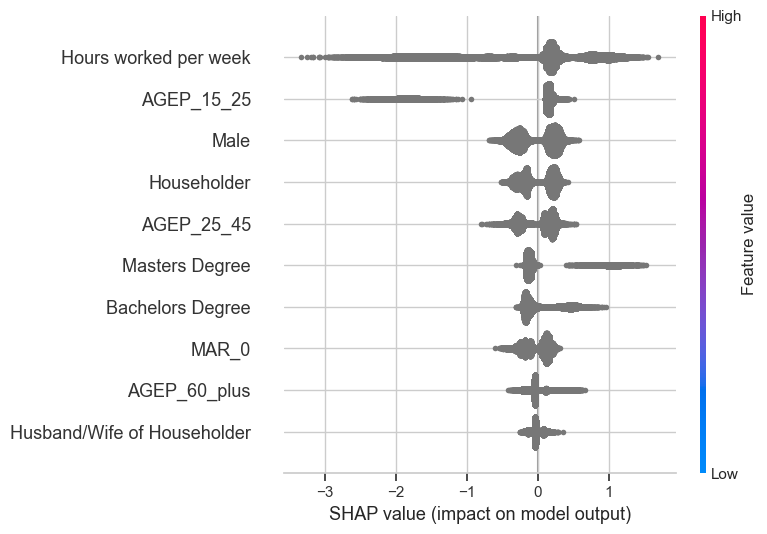

In [78]:
explainer = shap.Explainer(best_model, feature_names = all_feature_names)

tree_shap_values = explainer(X_test_enc)
tree_shap_values.feature_names = rename_features(tree_shap_values)
shap.summary_plot(tree_shap_values, X_test_enc, max_display=10)

In [79]:
# Save Tree SHAP-values
np.save("treeshap_values_fairlearn.npy", tree_shap_values.values)

# **Simple FFNN**

Hyperparamter grid search and training the best model

In [104]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

param_dist = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

def sample_params(param_dist):
    return {k: np.random.choice(v) for k, v in param_dist.items()}

n_iter = 10
input_dim = X_train_enc.shape[1]
results = []

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))


for i in range(n_iter):
    params = sample_params(param_dist)
    print(f"Trial {i+1}/{n_iter} with params: {params}")

    model = build_ffnn(
        input_dim=input_dim,
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    model.fit(
        X_train_enc, y_train_arr,
        validation_data=(X_val_enc, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0, 
        class_weight=class_weights
        
    )

    val_preds = model.predict(X_val_enc).ravel()
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"Val AUC: {val_auc:.4f}\n")

    results.append((params, val_auc))

# Find the best model
best_params, best_val_auc = max(results, key=lambda x: x[1])
print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")


# Build and train the best model
best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train_arr,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=class_weights)

Trial 1/10 with params: {'hidden_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step
Val AUC: 0.8908

Trial 2/10 with params: {'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 20}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step
Val AUC: 0.8886

Trial 3/10 with params: {'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 20}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step
Val AUC: 0.8890

Trial 4/10 with params: {'hidden_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step
Val AUC: 0.8922

Trial 5/10 with params: {'hidden_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step
Val AUC: 0.8918

Trial 6/10 with params: {'hidden_units': 64, 'dropout_rate': 0.4, 'learning_rat

In [106]:
print("\n=== Test Performance: ===")
test_preds= best_model_NN.predict(X_test_enc).ravel()
test_auc= roc_auc_score(y_test, test_preds)
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(y_test, test_preds > 0.5))


=== Test Performance: ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step
Test AUC: 0.8950
              precision    recall  f1-score   support

           0       0.88      0.77      0.83     45340
           1       0.71      0.84      0.77     29660

    accuracy                           0.80     75000
   macro avg       0.80      0.81      0.80     75000
weighted avg       0.82      0.80      0.80     75000



# Deep SHAP

In [116]:
# sample representative background set and sample size
background_size = 5000 
test_sample_size = 10000

# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_enc, y_train))

# stratified sample from test set
X_test_array = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test))
X_test_sample = X_test_array[test_sample_idx]

# set background 
background = X_train_enc[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# DeepSHAP values
explainer = shap.DeepExplainer(best_model_NN, background)
deep_shap_values = explainer.shap_values(X_test_sample).squeeze(-1)

/Users/linkamitome/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


In [117]:
# Save Deep SHAP values
np.save('deep_shap_values_fairlearn.npy', deep_shap_values)

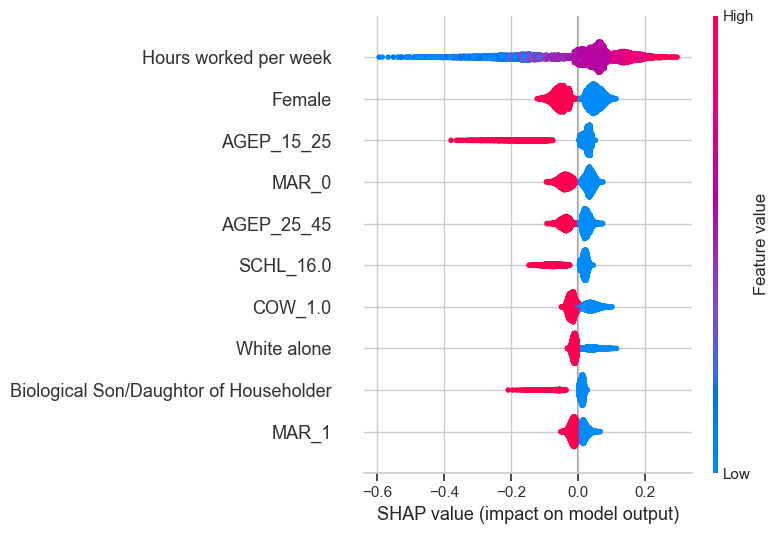

In [118]:
def rename_deep_shap_features(feature_name_list):
    custom_names = {
        'WKHP': 'Hours worked per week',
        'AGEP': 'Age',
        'SEX_1.0': 'Male',
        'SEX_2.0': 'Female',
        'RELP_0.0': 'Householder',
        'SCHL_21.0': 'Bachelors Degree',
        'SCHL_22.0': 'Masters Degree',
        'SCHL_23.0': 'Professional degree beyond a bachelors degree',
        'MAR_1.0': 'Married',
        'MAR_5.0': 'Never Married',
        'OCCP_3255.0': 'Occupation: Registered Nurse',
        'RELP_1.0': 'Husband/Wife of Householder',
        'RELP_2.0': 'Biological Son/Daughtor of Householder',
        'RAC1P_2.0': 'Black or African American alone',
        'RAC1P_1.0': 'White alone'
    }

    renamed_features = [custom_names.get(name, name) for name in feature_name_list]
    return renamed_features


renamed_feature_names = rename_deep_shap_features(all_feature_names)

shap.summary_plot(deep_shap_values, X_test_sample, feature_names=renamed_feature_names, max_display=10)

# Statistics

## Tree-shap

In [83]:
# load tree shap values
treeshap_values = np.load("treeshap_values_fairlearn.npy")

In [109]:
# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = treeshap_values[mask_A.values]
shap_female = treeshap_values[mask_B.values]
feature_names = all_feature_names

shapiro_list = []
shapiro_listW = []
levenes = []
z_list = []
t_test = []
print(len(feature_names))

normality_warnings = 0
varience_warnings = 0

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    # randomly sample 5000 instances of both groups
    try:
        group1 = np.random.choice(group1, size=5000, replace=False)
        group2 = np.random.choice(group2, size=5000, replace=False)
    except:
        pass # array is already less than 5000

    # normalise:
    group1 = preprocessing.normalize([group1], norm='l2')
    group2 = preprocessing.normalize([group2], norm='l2')
    
    # Shapiro-Wilk test
    shapiro_gr1 = shapiro(group1).pvalue
    shapiro_gr2 = shapiro(group2).pvalue
    shapiroW_gr1 = shapiro(group1).statistic
    shapiroW_gr2 = shapiro(group2).statistic
    shapiro_list.append([shapiro_gr1, shapiro_gr2])
    shapiro_listW.append([shapiroW_gr1, shapiroW_gr2])

    # Levenes test ---> depends on assumption of normality!
    w_stats, p_value = levene(group1, group2, center='mean')
    levenes.append([w_stats, p_value])

    # outlier test ---> depends on assumption of normality!
    z1 = np.abs(stats.zscore(group1))
    z2 = np.abs(stats.zscore(group2))
    z_list.append([z1, z2])

    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test.append([stat,pval])


print("Shapiro values: ", shapiro_list)
print("Shapiro statistic: ", shapiro_listW)
print("Levens values: ", levenes)

817


ValueError: Samples must be one-dimensional.

In [112]:
# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = treeshap_values[mask_A.values]
shap_female = treeshap_values[mask_B.values]
feature_names = all_feature_names

shapiro_list = []
shapiro_listW = []
levenes = []
z_list = []
t_test = []
print(len(feature_names))

normality_warnings = 0
varience_warnings = 0

for i, feature in enumerate(all_feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    # randomly sample 5000 instances of both groups
    try:
        group1 = np.random.choice(group1, size=5000, replace=False)
        group2 = np.random.choice(group2, size=5000, replace=False)
    except:
        pass # array is already less than 5000

    # normalise:
    
    group1 = preprocessing.normalize([group1], norm='l2')
    group2 = preprocessing.normalize([group2], norm='l2')
    
    # Shapiro-Wilk test
    shapiro_gr1 = shapiro(group1).pvalue
    shapiro_gr2 = shapiro(group2).pvalue
    shapiroW_gr1 = shapiro(group1).statistic
    shapiroW_gr2 = shapiro(group2).statistic
    shapiro_list.append([shapiro_gr1, shapiro_gr2])
    shapiro_listW.append([shapiroW_gr1, shapiroW_gr2])

    # Levenes test ---> depends on assumption of normality!
    w_stats, p_value = levene(group1, group2, center='mean')
    levenes.append([w_stats, p_value])

    # outlier test ---> depends on assumption of normality!
    z1 = np.abs(stats.zscore(group1))
    z2 = np.abs(stats.zscore(group2))
    z_list.append([z1, z2])

    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test.append([stat,pval])


print("Shapiro values: ", shapiro_list)
print("Shapiro statistic: ", shapiro_listW)
print("Levens values: ", levenes)

817


ValueError: Samples must be one-dimensional.

In [98]:
print("z-scores that deviate: ", z_list)
print("t-test  values: ",t_test)

z-scores that deviate:  [[array([0.33627796, 0.34134442, 0.43432298, ..., 0.34909043, 0.42717165,
       0.34018445], dtype=float32), array([0.38684663, 0.35758385, 0.3652859 , ..., 0.3580504 , 0.35276818,
       0.36319643], dtype=float32)], [array([1.4330435, 0.6851995, 1.0763229, ..., 0.8288238, 1.094602 ,
       0.8866758], dtype=float32), array([1.1973076 , 0.76661295, 0.5894982 , ..., 1.273231  , 1.2033714 ,
       0.35999006], dtype=float32)], [array([0.4792991 , 0.20227368, 0.34243822, ..., 0.393237  , 0.43193468,
       0.4486312 ], dtype=float32), array([1.5914277 , 0.62829983, 0.21671633, ..., 0.7628989 , 0.7113267 ,
       0.6738721 ], dtype=float32)], [array([0.24287905, 2.194636  , 0.4391117 , ..., 0.33676025, 0.23137623,
       1.0137887 ], dtype=float32), array([0.09807999, 0.13941395, 0.18742996, ..., 0.65239686, 0.1632441 ,
       1.219824  ], dtype=float32)], [array([0.04146695, 0.15968722, 0.2194746 , ..., 0.6524563 , 0.08517495,
       1.8199617 ], dtype=float32), 

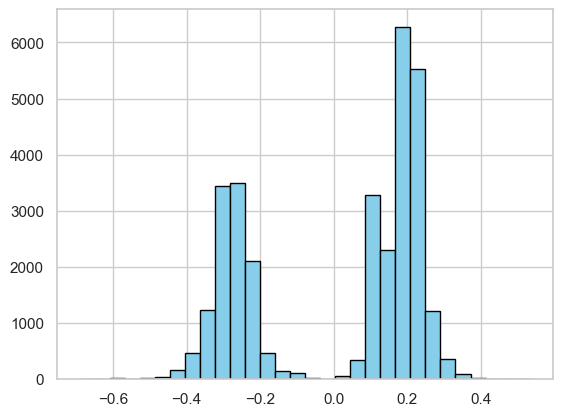

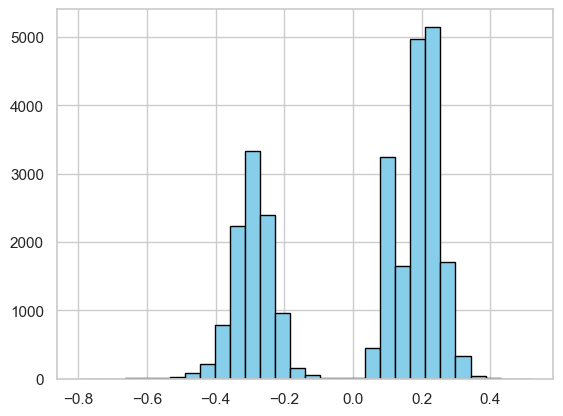

In [99]:
import matplotlib.pyplot as plt
import numpy as np

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i+1]
    group2 = shap_female[:, i+1]

    plt.hist(group1, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    plt.hist(group2, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    break

## Deep SHAP

In [119]:
deepshap_values = np.load('deep_shap_values_fairlearn.npy')

In [124]:
# recover original X_test from sample 
X_test_sample_meta = X_test.iloc[test_sample_idx]

In [125]:
mask_A = (X_test_sample_meta['SEX'] == 1) & (X_test_sample_meta['RAC1P'] == 1)
mask_B = (X_test_sample_meta['SEX'] == 2) & (X_test_sample_meta['RAC1P'] == 1)

shap_male = deepshap_values[mask_A.values]
shap_female = deepshap_values[mask_B.values]

feature_names = all_feature_names

shapiro_list = []
shapiro_listW = []
levenes = []
z_list = []
t_test = []
print(len(feature_names))

normality_warnings = 0
varience_warnings = 0

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    # randomly sample 5000 instances of both groups
    try:
        group1 = np.random.choice(group1, size=5000, replace=False)
        group2 = np.random.choice(group2, size=5000, replace=False)
    except:
        pass # array is already less than 5000

    # normalise:
    '''
    group1 = preprocessing.normalize([group1], norm='l2')
    group2 = preprocessing.normalize([group2], norm='l2')
    '''
    # Shapiro-Wilk test
    shapiro_gr1 = shapiro(group1).pvalue
    shapiro_gr2 = shapiro(group2).pvalue
    shapiroW_gr1 = shapiro(group1).statistic
    shapiroW_gr2 = shapiro(group2).statistic
    shapiro_list.append([shapiro_gr1, shapiro_gr2])
    shapiro_listW.append([shapiroW_gr1, shapiroW_gr2])

    # Levenes test ---> depends on assumption of normality!
    w_stats, p_value = levene(group1, group2, center='mean')
    levenes.append([w_stats, p_value])

    # outlier test ---> depends on assumption of normality!
    z1 = np.abs(stats.zscore(group1))
    z2 = np.abs(stats.zscore(group2))
    z_list.append([z1, z2])

    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test.append([stat,pval])


print("Shapiro values: ", shapiro_list)
print("Shapiro statistic: ", shapiro_listW)
print("Levens values: ", levenes)

817


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/Users/linkamitome/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


Shapiro values:  [[0.0, 0.0], [0.0, 0.0], [2.5403628217649314e-36, 3.307183766435729e-38], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.89067366005151e-22, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 6.08064857618892e-28], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 3.583680692664287e-41], [1.5985347334979088e-28, 1.4586639374787945e-35], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 3.7345842767302426e-24], [0.0, 0.0], [0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 3.201198310693335e-22], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [7.212385158303023e-26, 3.134604446787

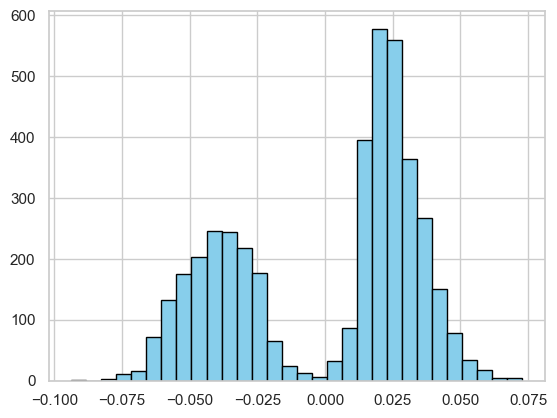

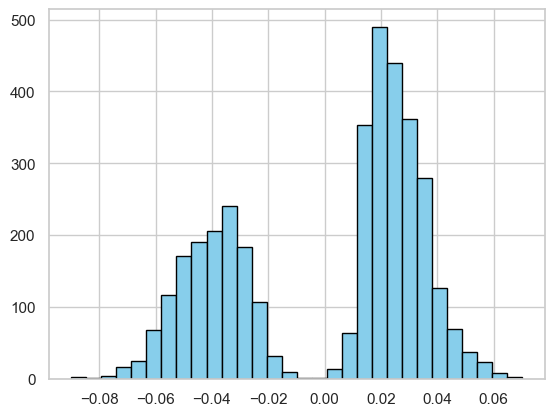

In [126]:
import matplotlib.pyplot as plt
import numpy as np

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i+1]
    group2 = shap_female[:, i+1]

    plt.hist(group1, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    plt.hist(group2, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    break

# T-test (incl. archive of automated loop for all subgroups)

In [ ]:
# effect size is what we need: 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3444174/

def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [ ]:
COW = {1:"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
2:"Employee of a private not-for-profit, tax-exempt, or charitable organization",
3:"Local government employee (city, county, etc.)",
4:"State government employee",
5:"Federal government employee",
6:"Self-employed in own not incorporated business, professional practice, or farm",
7:"Self-employed in own incorporated business, professional practice or farm",
8:"Working without pay in family business or farm",
9:"Unemployed and last worked 5 years ago or earlier or never worked"}
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
# numerical: AGEP and WKHP

In [ ]:
from scipy.stats import ttest_ind
print(shap_values.shape)
# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values.values[mask_A.values]
shap_female = shap_values.values[mask_B.values]
feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 
                 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 
                 'SEX_1.0', 'SEX_2.0', 
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 
                 'AGEP', 
                 'WKHP']


t_test_results = []

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    try:
        full_feature = feature.split('_')
        target = full_feature[0]
        index = int(float(full_feature[1]))
        if target == "COW":
            full_feature = (COW[index])
        elif target == "SCHL":
            full_feature = (SCHL[index])
        elif target == "MAR":
            full_feature = (MAR[index])
        elif target == "RELP":
            full_feature = (RELP[index])
        elif target == "SEX":
            full_feature = (SEX[index])
        elif target == "RAC1P":
            full_feature = (RAC1P[index])
    except:
        if full_feature == "WKHP":
            full_feature = "working hours per week"
        if full_feature == "AGEP":
            full_feature = "age"
    t_test_results.append({
        'feature': feature,
        'feature description': full_feature,
        't_stat': stat,
        'p_value': pval,
        'effect size': cohend(group1, group2),
        'mean_diff': group1.mean() - group2.mean()
        
    })
# Turn into a DataFrame
t_test_df = pd.DataFrame(t_test_results)

# Sort by p-value for significance
t_test_df = t_test_df.sort_values('effect size')
# Display top differences
print(t_test_df[['feature', 'feature description', 't_stat', 'p_value','effect size','mean_diff']].head(15))


(249675, 821)
      feature                                feature description     t_stat  \
29  SCHL_22.0                                    Master’s degree -22.570875   
23  SCHL_16.0                        Regular high school diploma -17.958226   
2     COW_3.0     Local government employee (city, county, etc.) -17.553266   
53  RELP_16.0  Institutionalized group quarters population. I... -17.194573   
27  SCHL_20.0                                 Associate’s degree -14.155942   
33    MAR_2.0                                            Widowed -13.040204   
60  RAC1P_4.0                                Alaska Native alone -11.774561   
22  SCHL_15.0                              Grade 12 (no diploma) -11.319410   
63  RAC1P_7.0   Native Hawaiian and Other Pacific Islander alone -10.883074   
25  SCHL_18.0                  Some college but less than 1 year -10.703204   
26  SCHL_19.0    1 or more years of college credit but no degree -10.562122   
40   RELP_3.0                         

In [ ]:
# print the columns of those that have an effect size stronger than 0.1
subset1 = t_test_df[t_test_df['effect size'] > 0.1 ]
subset2 = t_test_df[t_test_df['effect size'] < -0.1 ]
print(subset1)
print(subset2)

   feature                                feature description     t_stat  \
1  COW_2.0  Employee of a private not-for-profit, tax-exem...  24.608421   

         p_value  effect size  mean_diff  
1  1.825067e-133     0.113952     0.0035  
      feature feature description     t_stat        p_value  effect size  \
29  SCHL_22.0     Master’s degree -22.570875  1.225486e-112    -0.103964   

    mean_diff  
29  -0.033307  


In [ ]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [1, 2, 3, 4, 5],  # to-do: binarise
        'AGEPcat': ['15-25', '25-45', '45-60', '60+']
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 

    return subgroups

# e.g. 
# subgroups = extract_subgroups(X_test_filtered, 'SEX', 'RAC1P')

def t_test_all_subgroups(df, shap_values, attr1, attr2):

    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []

    feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 
                 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 
                 'SEX_1.0', 'SEX_2.0', 
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 
                 'AGEPcat_25-45', 'AGEPcat_45-60', 'AGEPcat_15-25', 'AGEPcat_60+',
                 'WKHP']

    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):
        shap1 = shap_values.values[mask1]
        shap2 = shap_values.values[mask2]

        # skip if there are no instances belonging to the subgroup
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        for i, feature in enumerate(feature_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]
            
            stat, pval = ttest_ind(group1, group2, equal_var=False) # Welch's t-test to account for variance differences
            effect_size = cohend(group1, group2)
            mean_diff = group1.mean() - group2.mean()

            full_feature = feature
            
            try:
                parts = feature.split('_')
                if len(parts) == 2:
                    target = parts[0]
                    index = int(float(parts[1]))

                    full_feature = (
                        COW[index] if target == 'COW' else
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        AGEPcat[index] if target == 'AGEPcat' else 
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                't_stat': stat,
                'p_value': pval,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })
            
    return pd.DataFrame(t_test_results)

In [ ]:
results_df = t_test_all_subgroups(X_test, shap_values, attr1='MAR', attr2='SEX').sort_values('effect_size', ascending=False)
significant_results = results_df[results_df['effect_size'].abs() > 0.2] # filter for (abs) cohen d value over 0.1

In [ ]:
print(significant_results)

                subgroup1            subgroup2  feature feature description  \
5855  MAR_2_AGEPcat_15-25  MAR_5_AGEPcat_25-45  MAR_2.0             Widowed   
5784  MAR_2_AGEPcat_15-25  MAR_5_AGEPcat_15-25  MAR_2.0             Widowed   
5358  MAR_2_AGEPcat_15-25  MAR_3_AGEPcat_45-60  MAR_2.0             Widowed   
5287  MAR_2_AGEPcat_15-25  MAR_3_AGEPcat_25-45  MAR_2.0             Widowed   
5926  MAR_2_AGEPcat_15-25  MAR_5_AGEPcat_45-60  MAR_2.0             Widowed   
...                   ...                  ...      ...                 ...   
246   MAR_1_AGEPcat_15-25  MAR_2_AGEPcat_15-25  MAR_2.0             Widowed   
3016  MAR_1_AGEPcat_45-60  MAR_3_AGEPcat_15-25  MAR_3.0            Divorced   
1809  MAR_1_AGEPcat_25-45  MAR_3_AGEPcat_15-25  MAR_3.0            Divorced   
2731  MAR_1_AGEPcat_45-60  MAR_2_AGEPcat_15-25  MAR_2.0             Widowed   
1524  MAR_1_AGEPcat_25-45  MAR_2_AGEPcat_15-25  MAR_2.0             Widowed   

        t_stat       p_value  effect_size  mean_dif

# Fairness evaluation

### Conditional statistical parity

In [ ]:
# should work on both single and intersectional groups
# convert y_pred, y_true to numpy arrays first

def conditional_statistical_parity(y_true, y_pred, protected_attr):
    strata = np.unique(y_true)
    groups = np.unique(protected_attr)
    diffs = []

    for label in strata:
        idx = (y_true == label)
        for g1, g2 in combinations(groups, 2):
            idx_g1 = idx & (protected_attr == g1)
            idx_g2 = idx & (protected_attr == g2)

            if np.sum(idx_g1) == 0 or np.sum(idx_g2) == 0:
                continue

            rate_g1 = np.mean(y_pred[idx_g1])
            rate_g2 = np.mean(y_pred[idx_g2])
            diffs.append(abs(rate_g1 - rate_g2))

    return np.nanmean(diffs) if diffs else np.nan


### Equalized odds (TPR & FPR)

In [ ]:
# should work on both single and intersectional groups
# convert y_pred, y_true to numpy arrays first

def equalized_odds(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    tpr_diffs, fpr_diffs = [], []

    for g1, g2 in combinations(groups, 2):
        for label, name in [(1, "TPR"), (0, "FPR")]:
            idx1 = (y_true == label) & (protected_attr == g1)
            idx2 = (y_true == label) & (protected_attr == g2)

            if np.sum(idx1) == 0 or np.sum(idx2) == 0:
                continue

            rate1 = np.mean(y_pred[idx1])
            rate2 = np.mean(y_pred[idx2])
            diff = abs(rate1 - rate2)

            (tpr_diffs if label == 1 else fpr_diffs).append(diff)

    return {
        "TPR_diff": np.nanmean(tpr_diffs) if tpr_diffs else np.nan,
        "FPR_diff": np.nanmean(fpr_diffs) if fpr_diffs else np.nan
    }
